# Data generator

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from yolo3.utils import get_random_data
from yolo3.model import preprocess_true_boxes

In [ ]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [ ]:
annotation_path = '2012_train.txt'

In [ ]:
with open(annotation_path) as f:
    lines = f.readlines()

In [ ]:
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)

In [ ]:
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'

input_shape = (416,416) # multiple of 32, hw

## data_generator function

In [ ]:
val_split = 0.1
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

annotation_lines = lines[:num_train]

### get_random_data function

In [ ]:
i = 1
# Original image
annotation_line = annotation_lines[i]
line = annotation_line.split()
image = Image.open(line[0])
box = np.array([np.array(list(map(int,box.split(',')))) for box in line[1:]])

image = np.array(image)
plt.imshow(image)
image.shape

In [ ]:
# Image with resizing and padding to become input_shape shape WITHOUT transforming image
# value be normalized = /255
image, box = get_random_data(annotation_line, input_shape, random=False)
plt.imshow(image)
image.shape

In [ ]:
# Randomly Transforming image: resize, transition, flip and distort color
# value be normalized = /255
image, box = get_random_data(annotation_line, input_shape, random=True)
plt.imshow(image)
image.shape

In [ ]:
# Draw bounding box
k = 0
x1 = int(box[k][0])
y1 = int(box[k][1])
x2 = int(box[k][2])
y2 = int(box[k][3])

cv2.rectangle(image, (x1, y1), (x2, y2), (255, 255, 0), 2)

plt.imshow(image)
image.shape

### preprocess_true_boxes function

In [ ]:
box_data = []
box[1] = box[0]
box_data.append(box)
box_data = np.array(box_data)

class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

In [ ]:
true_boxes = box_data

In [ ]:
y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
# there are 3 level of feature map by default
print(y_true[0].shape)
print(y_true[1].shape)
print(y_true[2].shape)

In [ ]:
assert (true_boxes[..., 4]<num_classes).all(), 'class id must be less than num_classes'
num_layers = len(anchors)//3 # default setting
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

true_boxes = np.array(true_boxes, dtype='float32')
input_shape = np.array(input_shape, dtype='int32')
# x,y is of center of boxes, w,h is the width and height of boxes
boxes_xy = (true_boxes[..., 0:2] + true_boxes[..., 2:4]) // 2
boxes_wh = true_boxes[..., 2:4] - true_boxes[..., 0:2]
# normalize into image coordinates (0,1)
true_boxes[..., 0:2] = boxes_xy/input_shape[::-1]
true_boxes[..., 2:4] = boxes_wh/input_shape[::-1]

# number of images in the batch, or batch_size
m = true_boxes.shape[0]
layer2stride = {0:32, 1:16, 2:8}
grid_shapes = [input_shape//layer2stride[l] for l in range(num_layers)]
# initialize y_true for correct output shapes
y_true = [np.zeros((m,grid_shapes[l][0],grid_shapes[l][1],len(anchor_mask[l]),5+num_classes),
    dtype='float32') for l in range(num_layers)]

# Expand dim to apply broadcasting.
anchors = np.expand_dims(anchors, 0)
anchor_maxes = anchors / 2.
anchor_mins = -anchor_maxes
valid_mask = boxes_wh[..., 0]>0

In [ ]:
anchor_mins

In [ ]:
b = 0

# Discard zero rows.
wh = boxes_wh[b, valid_mask[b]]
if len(wh)==0:
    print("len 0")
else:
    # Expand dim to apply broadcasting.
    wh = np.expand_dims(wh, -2)
    box_maxes = wh / 2.
    box_mins = -box_maxes

    intersect_mins = np.maximum(box_mins, anchor_mins)
    intersect_maxes = np.minimum(box_maxes, anchor_maxes)
    intersect_wh = np.maximum(intersect_maxes - intersect_mins, 0.)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]
    box_area = wh[..., 0] * wh[..., 1]
    anchor_area = anchors[..., 0] * anchors[..., 1]
    iou = intersect_area / (box_area + anchor_area - intersect_area)

    # Find best anchor for each true box
    best_anchor = np.argmax(iou, axis=-1)

In [ ]:
best_anchor

In [ ]:
iou

In [ ]:
intersect_mins

In [ ]:
box_mins

In [ ]:
anchor_mins

In [ ]:
anchors

In [ ]:
anchor_maxes

In [ ]:
anchor_mins

In [ ]:
valid_mask

In [ ]:
wh

In [ ]:
box_maxes

In [ ]:
box_mins

In [ ]:
intersect_mins

In [ ]:
intersect_maxes

In [ ]:
intersect_wh

In [ ]:
anchors

In [ ]:
intersect_area

In [ ]:
box_area

In [ ]:
best_anchor

In [ ]:
for t, n in enumerate(best_anchor):
    print(t, n)

In [ ]:
grid_shapes

In [ ]:
true_boxes

In [ ]:
anchor_mask[0].index(8)

In [ ]:
true_boxes[0,0,4]

In [ ]:
true_boxes[0,0,0:4]

# Yolo loss

## Review yolo_loss function

### Prepare auguments

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from yolo3.utils import get_random_data
from yolo3.model import *
from train import *

def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [2]:
annotation_path = '2012_train.txt'
log_dir = 'logs/000/'
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

input_shape = (416,416) # multiple of 32, hw

In [3]:
K.clear_session() # get a new session
image_input = Input(shape=(None, None, 3))
h, w = input_shape
num_anchors = len(anchors)


In [4]:
model_body = yolo_body(image_input, num_anchors//3, num_classes)
print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

Create YOLOv3 model with 9 anchors and 20 classes.


In [5]:
weights_path = 'model_data/yolo_weights.h5'
model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
print('Load weights {}.'.format(weights_path))

/Users/chaunguyen/anaconda2/envs/keras/lib/python3.5/site-packages/keras/engine/saving.py:1008: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((1, 1, 1024, 75) vs (255, 1024, 1, 1)).
  weight_values[i].shape))
/Users/chaunguyen/anaconda2/envs/keras/lib/python3.5/site-packages/keras/engine/saving.py:1008: UserWarning: Skipping loading of weights for layer conv2d_59 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/Users/chaunguyen/anaconda2/envs/keras/lib/python3.5/site-packages/keras/engine/saving.py:1008: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((1, 1, 512, 75) vs (255, 512, 1, 1)).
  weight_values[i].shape))
/Users/chaunguyen/anaconda2/envs/keras/lib/python3.5/site-packages/keras/engine/saving.py:1008: UserWarning: Skipping loading of weights for layer conv2d_67 due to mismatch in shape ((75,) vs (255,)).
  weight_values[i].shape))
/Users/chaunguyen/anaconda2/envs/keras/lib/pyt

Load weights model_data/yolo_weights.h5.


### Get model body output and y_true

In [6]:
val_split = 0.1
with open(annotation_path) as f:
    lines = f.readlines()
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

annotation_lines = lines[:num_train]

(416, 416, 3)

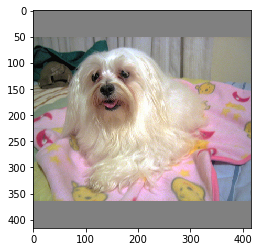

In [7]:
i = 1
# Original image
annotation_line = annotation_lines[i]
# Image with resizing and padding to become input_shape shape WITHOUT transforming image
# value be normalized = /255
image, box = get_random_data(annotation_line, input_shape, random=False)
plt.imshow(image)
image.shape

In [8]:
box_data = []
# box[1] = box[0]
box_data.append(box)
box_data = np.array(box_data)

y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)

In [9]:
model_body_outputs = model_body.predict(np.array([image]))

In [10]:
model_body_outputs[2].shape

(1, 52, 52, 75)

In [11]:
args = [*model_body_outputs, *y_true]

In [12]:
len(args)

6

### Investigate yolo_loss

In [27]:
sess = K.get_session()

In [22]:
num_layers = len(anchors)//3 # default setting
yolo_outputs = args[:num_layers]
y_true = args[num_layers:]
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]
y_true[0].dtype

dtype('float32')

In [25]:
input_shape = K.cast(K.shape(yolo_outputs[0])[1:3] * 32, dtype='float32')

In [26]:
input_shape

<tf.Tensor 'Cast:0' shape=(2,) dtype=float32>

In [30]:
sess.run(input_shape)

array([416., 416.], dtype=float32)

In [32]:
grid_shapes = [K.cast(K.shape(yolo_outputs[l])[1:3], dtype='float32') for l in range(num_layers)]

In [33]:
sess.run(grid_shapes)

[array([13., 13.], dtype=float32),
 array([26., 26.], dtype=float32),
 array([52., 52.], dtype=float32)]

In [34]:
m = K.shape(yolo_outputs[0])[0] # batch size, tensor
sess.run(m)

1

In [36]:
mf = K.cast(m, dtype='float32')
sess.run(mf)

1.0

In [57]:
l = range(num_layers)[0]

In [58]:
object_mask = y_true[l][..., 4:5]
object_mask.shape

(1, 13, 13, 3, 1)

In [59]:
np.nonzero(object_mask)

(array([0]), array([6]), array([6]), array([2]), array([0]))

In [60]:
object_mask[np.nonzero(object_mask)]

array([1.], dtype=float32)

In [62]:
true_class_probs = y_true[l][..., 5:]
true_class_probs.shape

(1, 13, 13, 3, 20)

### Go to yolo_head
### grid, raw_pred, pred_xy, pred_wh = yolo_head(feats, anchors, num_classes, input_shape, calc_loss=True)

In [65]:
anchors_backup = np.copy(anchors)

In [66]:
feats = yolo_outputs[l]
anchors = anchors[anchor_mask[l]]

In [67]:
anchors

array([[116.,  90.],
       [156., 198.],
       [373., 326.]])

In [73]:
num_anchors = len(anchors)
num_anchors

3

In [77]:
# Reshape to batch, height, width, num_anchors, box_params.
anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])
sess.run(anchors_tensor).shape

(1, 1, 1, 3, 2)

In [78]:
grid_shape = K.shape(feats)[1:3] # height, width
sess.run(grid_shape)

array([13, 13], dtype=int32)

In [81]:
grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]), [1, grid_shape[1], 1, 1])
sess.run(grid_y)

array([[[[ 0]],

        [[ 0]],

        [[ 0]],

        [[ 0]],

        [[ 0]],

        [[ 0]],

        [[ 0]],

        [[ 0]],

        [[ 0]],

        [[ 0]],

        [[ 0]],

        [[ 0]],

        [[ 0]]],


       [[[ 1]],

        [[ 1]],

        [[ 1]],

        [[ 1]],

        [[ 1]],

        [[ 1]],

        [[ 1]],

        [[ 1]],

        [[ 1]],

        [[ 1]],

        [[ 1]],

        [[ 1]],

        [[ 1]]],


       [[[ 2]],

        [[ 2]],

        [[ 2]],

        [[ 2]],

        [[ 2]],

        [[ 2]],

        [[ 2]],

        [[ 2]],

        [[ 2]],

        [[ 2]],

        [[ 2]],

        [[ 2]],

        [[ 2]]],


       [[[ 3]],

        [[ 3]],

        [[ 3]],

        [[ 3]],

        [[ 3]],

        [[ 3]],

        [[ 3]],

        [[ 3]],

        [[ 3]],

        [[ 3]],

        [[ 3]],

        [[ 3]],

        [[ 3]]],


       [[[ 4]],

        [[ 4]],

        [[ 4]],

        [[ 4]],

        [[ 4]],

        [[ 4]],

      

In [82]:
grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]), [grid_shape[0], 1, 1, 1])
sess.run(grid_x)

array([[[[ 0]],

        [[ 1]],

        [[ 2]],

        [[ 3]],

        [[ 4]],

        [[ 5]],

        [[ 6]],

        [[ 7]],

        [[ 8]],

        [[ 9]],

        [[10]],

        [[11]],

        [[12]]],


       [[[ 0]],

        [[ 1]],

        [[ 2]],

        [[ 3]],

        [[ 4]],

        [[ 5]],

        [[ 6]],

        [[ 7]],

        [[ 8]],

        [[ 9]],

        [[10]],

        [[11]],

        [[12]]],


       [[[ 0]],

        [[ 1]],

        [[ 2]],

        [[ 3]],

        [[ 4]],

        [[ 5]],

        [[ 6]],

        [[ 7]],

        [[ 8]],

        [[ 9]],

        [[10]],

        [[11]],

        [[12]]],


       [[[ 0]],

        [[ 1]],

        [[ 2]],

        [[ 3]],

        [[ 4]],

        [[ 5]],

        [[ 6]],

        [[ 7]],

        [[ 8]],

        [[ 9]],

        [[10]],

        [[11]],

        [[12]]],


       [[[ 0]],

        [[ 1]],

        [[ 2]],

        [[ 3]],

        [[ 4]],

        [[ 5]],

      

In [84]:
grid = K.concatenate([grid_x, grid_y])
sess.run(grid).shape

(13, 13, 1, 2)

In [86]:
grid = K.cast(grid, dtype='float32')

In [87]:
feats.shape

(1, 13, 13, 75)

In [89]:
feats = K.reshape(feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])
sess.run(feats).shape

(1, 13, 13, 3, 25)

In [90]:
feats

<tf.Tensor 'Reshape_12:0' shape=(?, ?, ?, 3, 25) dtype=float32>

In [92]:
raw_true_xy = y_true[l][..., :2]*grid_shapes[l][::-1] - grid
raw_true_xy

<tf.Tensor 'sub_1:0' shape=(1, 13, 13, 3, 2) dtype=float32>

In [93]:
sess.run(raw_true_xy)

array([[[[[  0.,   0.],
          [  0.,   0.],
          [  0.,   0.]],

         [[ -1.,   0.],
          [ -1.,   0.],
          [ -1.,   0.]],

         [[ -2.,   0.],
          [ -2.,   0.],
          [ -2.,   0.]],

         ...,

         [[-10.,   0.],
          [-10.,   0.],
          [-10.,   0.]],

         [[-11.,   0.],
          [-11.,   0.],
          [-11.,   0.]],

         [[-12.,   0.],
          [-12.,   0.],
          [-12.,   0.]]],


        [[[  0.,  -1.],
          [  0.,  -1.],
          [  0.,  -1.]],

         [[ -1.,  -1.],
          [ -1.,  -1.],
          [ -1.,  -1.]],

         [[ -2.,  -1.],
          [ -2.,  -1.],
          [ -2.,  -1.]],

         ...,

         [[-10.,  -1.],
          [-10.,  -1.],
          [-10.,  -1.]],

         [[-11.,  -1.],
          [-11.,  -1.],
          [-11.,  -1.]],

         [[-12.,  -1.],
          [-12.,  -1.],
          [-12.,  -1.]]],


        [[[  0.,  -2.],
          [  0.,  -2.],
          [  0.,  -2.]],

    